In [1]:
import pandas as pd 
import string 

#Scrapping 
import requests
from bs4 import BeautifulSoup
import time
import random

#Machine Learning - Classification 
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#Visualisation
import seaborn as sns
import matplotlib.pyplot as plt 

#NPL 
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize 
from nltk.corpus import stopwords

In [2]:
head={'Accept':'text/html,application/xhtml+xm…ml;q=0.9,image/webp,*/*;q=0.8'.encode('cp1252'),
'Accept-Encoding':'gzip, deflate, br'.encode('cp1252'),
'Accept-Language':'fr,fr-FR;q=0.8,en-US;q=0.5,en;q=0.3'.encode('cp1252'),
'Connection':'keep-alive'.encode('cp1252'),
'Host':'www.amazon.fr'.encode('cp1252'),
'TE':'Trailers'.encode('cp1252'),
'Upgrade-Insecure-Requests':'1'.encode('cp1252'),
'User-Agent':'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:74.0) Gecko/20100101 Firefox/74.0'.encode('cp1252')}

# Scrapping Commentaires & Notes d' un Produit sur le site d'Amazon

In [3]:
base = "https://www.amazon.fr/Samsung-Galaxy-Dual-32GB-SM-A105F/product-reviews/B07KWX9GNV/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews"

commentaire = []
notes = []

for i in range(1,166):
    url=base+"&pageNumber="+str(i)
    time.sleep(random.randrange(0, 2))
    r=requests.get(url,headers=head)
    soup = BeautifulSoup(r.content,"html.parser")
    #class="a-row a-spacing-none"
    #class="a-link-normal"
    #for elem in soup.findAll('div',{'data-hook':'review-star-rating'}):
    for elem in soup.findAll('div',{'class':"a-section celwidget"}):
        notes.append(elem.find('span',{"class":"a-icon-alt"}).text)
    for elem in soup.findAll('span',{'data-hook':'review-body'}) :
        commentaire.append(elem.text.strip())

In [4]:
## On vérifie qu' on a le meme nombre
print(len(commentaire))
print(len(notes))

1644
1644


# Nettoyage des Données 

In [7]:
## on parcourt la liste des notes et on remplace les ",0" par "" et on les transforme en int 
for i,j in enumerate(notes) : 
    if len(j[:3]) < 2:
        notes[i] = 0
    else:
        notes[i] = int(notes[i][:3].replace(',0',''))

In [9]:
##On insère nos Notes et nos Commentaires dans un dataframe
Data = pd.DataFrame({"note":notes,"commentaire":commentaire})

In [10]:
## Vérification
Data

,note,commentaire
0,3,Dommage que la prise d'alimentation secteur ne...
1,3,"Bonjour, j'ai acheté cette appareil mais il e..."
2,4,Rien à redire sur la qualité du téléphone pour...
3,5,Ravie de mon achat. Pourtant j'avais lu des av...
4,4,excellent telephone rapport qualité prix on ne...
...,...,...
1639,4,Good budget phone from Samsung . It was for a ...
1640,4,Sehr schnell geliefert gut verpackt gerne wieder
1641,5,Such a nice phone...
1642,5,"Bien, barato y para lo básico va perfecto."


In [11]:
## On regarde le nombre de Valeurs
Data['note'].value_counts()

5    1032
4     367
1     122
3      91
2      32
Name: note, dtype: int64

In [12]:
## On transforme les notes en les separant en deux classes 0 ou 1 
Data.loc[Data[Data['note'] <= 3].index,'note']= 0
Data.loc[Data[Data['note'] > 3].index,'note']= 1

In [13]:
## On vérifie
Data

,note,commentaire
0,0,Dommage que la prise d'alimentation secteur ne...
1,0,"Bonjour, j'ai acheté cette appareil mais il e..."
2,1,Rien à redire sur la qualité du téléphone pour...
3,1,Ravie de mon achat. Pourtant j'avais lu des av...
4,1,excellent telephone rapport qualité prix on ne...
...,...,...
1639,1,Good budget phone from Samsung . It was for a ...
1640,1,Sehr schnell geliefert gut verpackt gerne wieder
1641,1,Such a nice phone...
1642,1,"Bien, barato y para lo básico va perfecto."


In [15]:
## On Vérifie qu'on a bien 2 classes 
Data['note'].value_counts()

1    1399
0     245
Name: note, dtype: int64

In [16]:
## On remplace le nom de la colonne note par label pour le nom de classe 
Data.rename(columns={'note': 'label'}, inplace=True) 

In [17]:
## On Vérifie
Data

,label,commentaire
0,0,Dommage que la prise d'alimentation secteur ne...
1,0,"Bonjour, j'ai acheté cette appareil mais il e..."
2,1,Rien à redire sur la qualité du téléphone pour...
3,1,Ravie de mon achat. Pourtant j'avais lu des av...
4,1,excellent telephone rapport qualité prix on ne...
...,...,...
1639,1,Good budget phone from Samsung . It was for a ...
1640,1,Sehr schnell geliefert gut verpackt gerne wieder
1641,1,Such a nice phone...
1642,1,"Bien, barato y para lo básico va perfecto."


In [18]:
## On rentre tous les mots avec peu de sens
stop=['le','la','les','de','du','des','un','une','je','tu','j','t','il','ces','ses','son','ceux','cette',
      'chaque','chaques','celle',"celui","ce","celles","cela","est"]

In [19]:
## Fonction pour nettoyer les commentaires
import re
import unidecode

def nettoyage(texte):
    t=[]
    texte=str(texte)
    texte=unidecode.unidecode(texte).replace('\'',' ').replace('\n',' ')
    # Je ne garde que les éléments non numériques et sans les . ,
    p='([^0-9\'".,;]{1,})'
    for elem in re.findall(p,texte):
        for el in elem.split():
            if el.lower() in stop or len(el) < 3:
                continue
            else :
                t.append(el)
    return ' '.join(t)

In [20]:
## On teste
nettoyage("Bonjour, je n ai pas aimé le model 48B45, son autonomie est pourrie voilà")

'Bonjour pas aime model autonomie pourrie voila'

In [21]:
## On applique le Nettoyage
Data['commentaire']= Data['commentaire'].apply(nettoyage)

In [22]:
## On vérifie 
Data

,label,commentaire
0,0,Dommage que prise alimentation secteur soit pa...
1,0,Bonjour achete appareil mais verrouille avec o...
2,1,Rien redire sur qualite telephone pour utilisa...
3,1,Ravie mon achat Pourtant avais avis negatifs s...
4,1,excellent telephone rapport qualite prix peut ...
...,...,...
1639,1,Good budget phone from Samsung was for friend
1640,1,Sehr schnell geliefert gut verpackt gerne wieder
1641,1,Such nice phone
1642,1,Bien barato para basico perfecto


# Construction du tfidf

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = TfidfVectorizer(ngram_range=(1, 2),min_df=4)
vectorizer = TfidfVectorizer(min_df=4)
X = vectorizer.fit_transform(Data['commentaire'])

In [24]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
len(vectorizer.get_feature_names())

805

# Modelisation

In [26]:
X=X
y=Data['label']

In [29]:
from sklearn.metrics import roc_curve , auc 

In [31]:
## Préparation du dataset de train et set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Entrainement

In [85]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
y_pred = clf.decision_function(X_test)

0.8481781376518218


In [91]:
from sklearn import svm
clf = svm.LinearSVC()
clf.fit(X_train, y_train)  
print(clf.score(X_test, y_test))
svm_pred = clf.decision_function(X_test)

0.8724696356275303


In [96]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
random_pred = clf.predict_proba(X_test)

0.8623481781376519


In [102]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier().fit(X_train, y_train)
print(clf.score(X_test, y_test))
SGD_pred = clf.decision_function(X_test)

0.8522267206477733


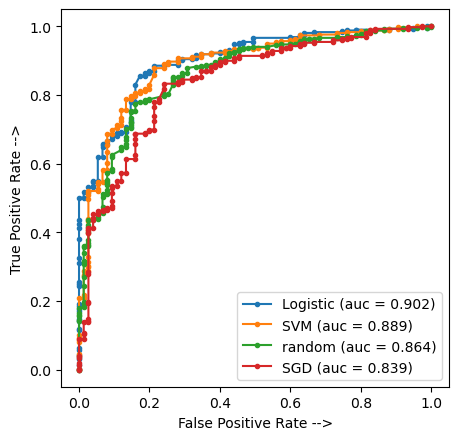

In [106]:
## On utilise le Roc AUC car notre dataset est biaisé il y a beaucoup
## plus de 1 que de 0 

logistic_fpr, logistic_tpr, threshold = roc_curve(y_test,y_pred)
auc_logistic = auc(logistic_fpr, logistic_tpr)

svm_fpr, svm_tpr, threshold = roc_curve(y_test, svm_pred)
auc_svm = auc(svm_fpr, svm_tpr)

random_fpr, random_tpr, threshold = roc_curve(y_test, random_pred[:,1])
auc_random = auc(random_fpr, random_tpr)

sgd_fpr, sgd_tpr, threshold = roc_curve(y_test, SGD_pred)
auc_sgd = auc(sgd_fpr, sgd_tpr)


plt.figure(figsize=(5, 5), dpi=100)

plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic (auc = %0.3f)' % auc_logistic)
plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM (auc = %0.3f)' % auc_svm)
plt.plot(random_fpr, random_tpr, marker='.', label='random (auc = %0.3f)' % auc_random)
plt.plot(sgd_fpr, sgd_tpr, marker='.', label='SGD (auc = %0.3f)' % auc_sgd)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()